train size= 3224
validation size= 570
Epoch 1/50, Train Loss: 1.60292279252819, Train Acc: 27.29528535980149, Val Loss: 1.5678239398532443, Val Acc: 30.526315789473685
Epoch 2/50, Train Loss: 1.3662229589387482, Train Acc: 30.148883374689827, Val Loss: 1.375831299357944, Val Acc: 32.280701754385966
Epoch 3/50, Train Loss: 1.3348476302390004, Train Acc: 36.75558312655087, Val Loss: 1.3144335746765137, Val Acc: 33.68421052631579
Epoch 4/50, Train Loss: 1.2461540441887051, Train Acc: 42.02853598014889, Val Loss: 1.1534691121843126, Val Acc: 45.614035087719294
Epoch 5/50, Train Loss: 1.089153350568285, Train Acc: 48.69727047146402, Val Loss: 1.142865988943312, Val Acc: 45.96491228070175
Epoch 6/50, Train Loss: 0.9351586898167928, Train Acc: 54.37344913151365, Val Loss: 0.8780632879998949, Val Acc: 55.614035087719294
Epoch 7/50, Train Loss: 0.8420557473220077, Train Acc: 58.34367245657568, Val Loss: 0.828868998421563, Val Acc: 58.77192982456141
Epoch 8/50, Train Loss: 0.7862671122831457, Tr

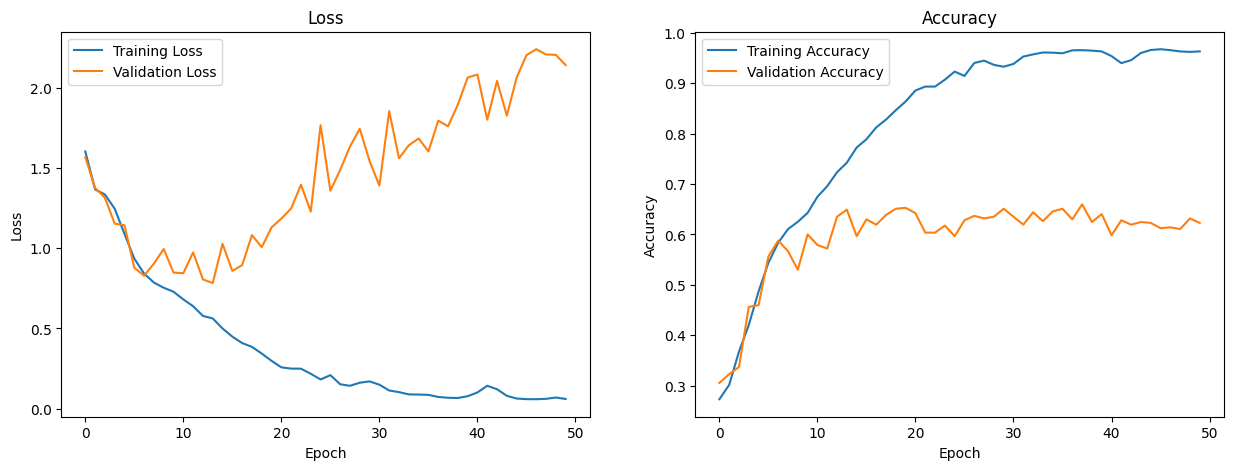

In [18]:
import torch
import numpy as np

from torch import optim, nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset


import torch
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt


def custom_loader(batch_size, shuffle_test=False, data_path='./Dataset/Train'):
    # Add the necessary transforms
    normalize = transforms.Normalize(mean=[0.5836, 0.4212, 0.3323],
                                 std=[0.2325, 0.1985, 0.1722])
    transform = transforms.Compose([
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomCrop(32, 4),
        transforms.Resize((48, 48)),  # Adjust this if your images are a different size
        # transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.ToTensor(),
        normalize
    ])

    # Load your dataset using ImageFolder
    master_dataset = datasets.ImageFolder(root=data_path, transform=transform)

    # Calculate the sizes of the splits
    total_size = len(master_dataset)
    train_size = int(0.85 * total_size)
    val_size = total_size - train_size
    #size of the training set
    print("train size=",train_size)
    print("validation size=",val_size)

    # Use random_split to create datasets for training, testing, and validation
    train_dataset, val_dataset = random_split(master_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader



class MultiLayerFCNet(nn.Module):
    def __init__(self,input_size, hidden_size, output_size):
        super().__init__()

        self.layer1=nn.Conv2d(3,32,4,padding=1,stride=1)
        self.B1 = nn.BatchNorm2d(32)
        self.layer2 = nn.Conv2d(32, 32, 4, padding=1, stride=1)
        self.B2 = nn.BatchNorm2d(32)
        self.Maxpool=nn.MaxPool2d(2)
        self.layer3 = nn.Conv2d(32, 64, 4, padding=1, stride=1)
        self.B3 = nn.BatchNorm2d(64)
        self.layer4 = nn.Conv2d(64, 64, 4, padding=1, stride=1)
        self.B4 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.5)
        
        # New layers
        self.layer5 = nn.Conv2d(64, 128, 4, padding=1, stride=1)
        self.B5 = nn.BatchNorm2d(128)
        self.layer6 = nn.Conv2d(128, 128, 4, padding=1, stride=1)
        self.B6 = nn.BatchNorm2d(128)
        self.layer7 = nn.Conv2d(128, 256, 4, padding=1, stride=1)
        self.B7 = nn.BatchNorm2d(256)
        self.layer8 = nn.Conv2d(256, 256, 4, padding=1, stride=1)
        self.B8 = nn.BatchNorm2d(256)
        
        # Calculate the size for the fully connected layer after additional max-pooling layers
        # Assuming two max-pooling operations in the existing layers
        self.fc_size = 256   # Now this is 256 * 3 * 3
        self.fc = nn.Linear(self.fc_size, output_size)

    def forward(self, x):
        # Pass through existing layers
        x = F.leaky_relu(self.B1(self.layer1(x)))
        x = self.Maxpool(F.leaky_relu(self.B2(self.layer2(x))))
        x = F.leaky_relu(self.B3(self.layer3(x)))
        x = self.Maxpool(F.leaky_relu(self.B4(self.layer4(x))))
        
        # Pass through new layers
        x = F.leaky_relu(self.B5(self.layer5(x)))
        x = F.leaky_relu(self.B6(self.layer6(x)))
        x = self.Maxpool(F.leaky_relu(self.B7(self.layer7(x))))
        x = self.Maxpool(F.leaky_relu(self.B8(self.layer8(x))))
        
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        return self.fc(x)

if __name__ == '__main__':

    batch_size = 64
    test_batch_size = 64
    input_size = 3 * 48 * 48  # 1 channels, 48x48 image size
    hidden_size = 50  # Number of hidden units
    output_size = 4  # Number of output classes 4
    num_epochs = 50

    # train_loader, _ = cifar_loader(batch_size)
    # _, test_loader = cifar_loader(test_batch_size)
    train_loader, val_loader = custom_loader(batch_size, data_path='./dataset/Train')
    # dataloader = DataLoader(dataset=IrisDataset('iris.data'),
    #                         batch_size=10,
    #                         shuffle=True)

    epochs = 50
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MultiLayerFCNet(input_size, hidden_size, output_size)
    model = nn.DataParallel(model)
    model.to(device)
    #model.load_state_dict(torch.load('path'))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    BestACC=0

# Lists to keep track of metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    model.train()
    for instances, labels in train_loader:
        instances, labels = instances.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(instances)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Record training metrics
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for instances, labels in val_loader:
            instances, labels = instances.to(device), labels.to(device)
            output = model(instances)
            loss = criterion(output, labels)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Record validation metrics
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    # Save the best model
    if val_accuracies[-1] > BestACC:
        BestACC=val_accuracies[-1]
        torch.save(model.state_dict(), './model/best_model.pth')

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Train Acc: {train_accuracies[-1] *100}, Val Loss: {val_losses[-1]}, Val Acc: {val_accuracies[-1]*100}")

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(val_losses, label='Validation Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Accuracy plot
axs[1].plot(train_accuracies, label='Training Accuracy')
axs[1].plot(val_accuracies, label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Show the plot
plt.show()


  